In [ ]:
#https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/MyDrive/RIR 2022 Synthetic Data") #changing working directory to google drive

In [4]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt') # needed for apply function 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import gensim
import spacy
from random import sample

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df = pd.read_pickle("/content/drive/MyDrive/RIR 2022 Synthetic Data/538_Tweets_BertTopic_Labels.pkl")

Loading the data and creating a learning dataset

In [6]:
df.head(2)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,year,normalized_tweet,label,sentence_embeddings,label_prob
0,8.920000e+17,CELLSSTITR,#bakerBREAKING : New Demands for Team Obama to...,Unknown,English,8/4/2017 13:28,8/4/2017 13:29,1988.0,800.0,807.0,NaN,Right,0.0,0.0,RightTroll,2017,#bakerBREAKING : New Demands for Team Obama to...,9,"[-0.06477942, 0.023317883, 0.01677053, -0.0454...",0.862739
1,8.980000e+17,CHIRRISMOGUI,Mad Max Just Got a BIG SURPRISE From Sheriff A...,United States,English,8/31/2017 17:51,8/31/2017 17:51,2948.0,817.0,318.0,NaN,Right,0.0,0.0,RightTroll,2017,Mad Max Just Got a BIG SURPRISE From Sheriff A...,-1,"[-0.10880535, -0.074772716, -0.08157185, -0.04...",0.000000


In [7]:
df_9= df[df['label'] == 9] # Selecting tweets label 9

In [8]:
df_9["training label"]= 1 # The label assignment 

<ipython-input-8-44ba43fd20d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9["training label"]= 1 # The label assignment


In [9]:
df_9 = df_9[["training label", "content"]]

In [10]:
df_9.head(2)

,training label,content
0,1,#bakerBREAKING : New Demands for Team Obama to...
73,1,Obama Exposed Securing $60 Million in Federal ...


In [11]:
df_khrys = pd.read_excel('twit2017.xlsx')

In [12]:
df_khrys.head(2)

,Unnamed: 0,accountType,added,author,isSyndicated,checked,city,cityCode,continent,continentCode,...,imageInfo.objects.id1...154,imageInfo.objects.id2...155,imageInfo.objects.id3...156,imageInfo.objects.id4...157,imageInfo.objects.id5...158,imageInfo.objects.confidence1...159,imageInfo.objects.confidence2...160,imageInfo.objects.confidence3...161,imageInfo.objects.confidence4...162,imageInfo.objects.confidence5...163
0,1,individual,2023-02-21T06:31:35.148+0000,pornlaw,False,False,Las Vegas,USA.NV.Las Vegas,North America,NORTH AMERICA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,2023-02-21T06:31:35.159+0000,Basil_Systems,False,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_khrys["training label"]= 0 # The label assignment 

In [13]:
#df_khrys["fullText"].iloc[1]

In [14]:
df_khrys = df_khrys[["training label","fullText"]]

In [15]:
df_khrys = df_khrys.rename(columns={"fullText":"content"})

In [16]:
df_khrys.head(2)

,training label,content
0,0,@Annetworth Absolutely...
1,0,sexy naked blond women anal girls of tobacco h...


In [17]:
df_final=pd.concat([df_9,df_khrys], axis=0)

,training label,content
0,1,#bakerBREAKING : New Demands for Team Obama to...
73,1,Obama Exposed Securing $60 Million in Federal ...


Preprocessing dataset

In [19]:
# remove the hashtags, mentions and unwanted characters.
def remove_content(text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) # To Remove http, https and the other normal url type special characters
    text=re.sub(r'\S+\.com\S+','',text) #remove urls."" mean no space or nothing
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    text =re.sub(r"^RT\s+",'',text) #remove rt's. re.sub() used to replace substrings; Syntax: re.sub(pattern,replacement,string) & will replace the matches in string with repl.
    return text

In [20]:
def process_text(text, stem= False): #clean text
    text=remove_content(text)
    text = re.sub('[^A-Za-z0-9]', ' ', text.lower()) #remove non-alphabets(?); lower is method applied to string text; matching each word in text-replacing with lower version
    tokenized_text = word_tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if word not in stopwords.words("english")
    ]
    if stem:
        stemmer = PorterStemmer() # initializig a poterstemmer object
        clean_text=[stemmer.stem(word) for word in clean_text]
    return ' '.join(clean_text) 
    #return clean_text

In [21]:
df_final["processed"] = df_final['content'].apply(lambda x: process_text(x, False))

In [22]:
df_final.head(2)

,training label,content,processed
0,1,#bakerBREAKING : New Demands for Team Obama to...,new demands team obama face criminal investiga...
73,1,Obama Exposed Securing $60 Million in Federal ...,obama exposed securing 60 million federal cont...


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [39]:
#X = df_final.processed

In [40]:
# Transform features
X = df_final.processed
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
#max_features reduces the dimensionality build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
X_tfidf = vectorizer.fit_transform(X)

In [41]:
# create target
y = df_final["training label"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

Naive Bayes Classifier (Just for Confirming the Pipeline):

---


class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, force_alpha='warn' fit_prior=True, class_prior=None)


---


The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html



In [43]:
from sklearn.naive_bayes import MultinomialNB

In [44]:
model = MultinomialNB(alpha=0.862)
model.fit (X_train, y_train) # alpha is assumed to be 1 to remove the problem of zero probability, 

MultinomialNB(alpha=0.862)

In [47]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve,average_precision_score
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("The Area Under the Receiver Operating Characteristic Curve (ROC AUC) from the prediction score is:", roc_auc_score(y_test, y_pred))
print("The average precision (precision-recall curve)", average_precision_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1628
           1       0.97      0.74      0.84       636

    accuracy                           0.92      2264
   macro avg       0.94      0.87      0.90      2264
weighted avg       0.93      0.92      0.92      2264

The Area Under the Receiver Operating Characteristic Curve (ROC AUC) from the prediction score is: 0.867076553397308
The average precision (precision-recall curve) 0.7946841587835523


In [29]:
#Please note that average precision score and PR AUC score should be almost same. Here there are slightly different due to small dataset which doesnot allow for mitigating the effects of the wiggle.

0.8938862018063518


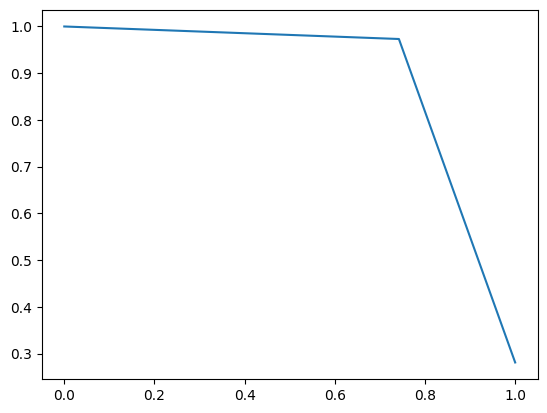

In [46]:
from sklearn.metrics import auc
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
import matplotlib.pyplot as plt
plt.plot(recall,precision)
plt.show()

In [35]:
no_features_during_fitting = model.n_features_in_ #10000. For checking the number of features.

HyperOpt for hyper parameter optimization 

In [25]:
!pip install hyperopt
!pip show hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
! git clone https://github.com/hyperopt/hyperopt-sklearn
! cd hyperopt-sklearn/
! pip install hyperopt-sklearn/
! pip install hpsklearn
! pip show hpsklearn

fatal: destination path 'hyperopt-sklearn' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./hyperopt-sklearn
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hpsklearn: filename=hpsklearn-1.0.3-py3-none-any.whl size=135027 sha256=92f8afbe4a7fbb85ee1f93d80b5af7e3e627b2b3d9071b8250f8fdd06187f1d4
  Stored in directory: /root/.cache/pip/wheels/c1/ce/cc/ea0d4699151f920a62712681017779f540311886271bc6d6f7
Successfully built hpsklearn
  Attempting uninstall: hpsklearn
    Found existing installation: hpsklearn 1.0.3
    Uninstalling hpsklearn-1.0.3:
      Successfully uninstalled hpsklearn-1.0.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
os.chdir("/content/drive/MyDrive/RIR 2022 Synthetic Data")

In [29]:
#https://hyperopt.github.io/hyperopt-sklearn/
#https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/
#https://towardsdatascience.com/hyperopt-hyperparameter-tuning-based-on-bayesian-optimization-7fa32dffaf29

In [30]:
from hpsklearn import HyperoptEstimator, tfidf,multinomial_nb, sgd_classifier
from hyperopt import tpe
from hyperopt import hp
#from sklearn.linear_model import SGDClassifier
#from sklearn.naive_bayes import MultinomialNB

In [31]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33, random_state=42)# Note I used the data directly from the dataframe

In [32]:
clf = hp.pchoice("swa",[multinomial_nb("multinomial")])

Exception ignored in: <function _xla_gc_callback at 0x7ff1e930b940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7ff1e930b940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [34]:
# Defining the search
estim = HyperoptEstimator(classifier=multinomial_nb("multi"), preprocessing=[tfidf("tfidf",max_features=10000)],algo=tpe.suggest, max_evals=50, trial_timeout=60)
#performing the search
estim.fit(X_train1, y_train1)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 15/16 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 94%|█████████▍| 16/17 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 95%|█████████▌| 19/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 97%|█████████▋| 37/38 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 39/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 40/41 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 43/44 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



 98%|█████████▊| 48/49 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



100%|██████████| 50/50 [00:00<00:00,  2.38trial/s, best loss: 0.025000000000000022]


In [35]:
#At the end of the run, the best-performing model can be evaluated on new data by calling the score() function
print(estim.score(X_test1,y_test1))

0.9553886925795053


In [37]:
print(estim.best_model())

{'learner': MultinomialNB(alpha=0.862), 'preprocs': (TfidfVectorizer(max_features=10000, ngram_range=(1, 3), norm=None,
                smooth_idf=False, stop_words='english', use_idf=False),), 'ex_preprocs': ()}


Using SGDCLassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve,average_precision_score
# Training classifier model 
clf = SGDClassifier()
clf.fit(X_train, y_train)

# model validation
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("The Area Under the Receiver Operating Characteristic Curve (ROC AUC) from the prediction score is:", roc_auc_score(y_test, y_pred))
print("The average precision (precision-recall curve)", average_precision_score(y_test, y_pred))
# Note ROC AUC is good for balanced dataset and PR AUC is good for imbalanced datasets

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1628
           1       0.98      0.90      0.94       636

    accuracy                           0.97      2264
   macro avg       0.97      0.94      0.96      2264
weighted avg       0.97      0.97      0.97      2264

The Area Under the Receiver Operating Characteristic Curve (ROC AUC) from the prediction score is: 0.9449067420765535
The average precision (precision-recall curve) 0.9065237435159299


In [ ]:
from sklearn.metrics import auc
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.9521243577577926


In [ ]:
#Please note that average precision score and PR AUC score should be almost same. Here there are slightly different due to small dataset which doesnot allow for mitigating the effects of the wiggle.

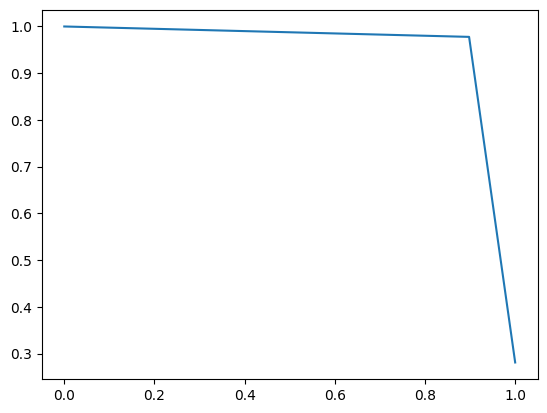

In [ ]:
import matplotlib.pyplot as plt
plt.plot(recall,precision)
plt.show()

ROC AUC vs PR AUC

What is common between ROC AUC and PR AUC is that they both look at prediction scores of classification models and not thresholded class assignments. What is different however is that ROC AUC looks at a true positive rate TPR and false positive rate FPR while PR AUC looks at positive predictive value PPV and true positive rate TPR.

Because of that if you care more about the positive class, then using PR AUC, which is more sensitive to the improvements for the positive class, is a better choice. One common scenario is a highly imbalanced dataset where the fraction of positive class, which we want to find (like in fraud detection), is small. I highly recommend taking a look at this kaggle kernel for a longer discussion on the subject of ROC AUC vs PR AUC for imbalanced datasets.

If you care equally about the positive and negative class or your dataset is quite balanced, then going with ROC AUC is a good idea.

In [ ]:
#The precision will be "how many are correctly classified among that class"
#The recall means "how many of this class you find over the whole number of element of this class"
#The support is the number of occurence of the given class in your dataset .
#The f1-score is the harmonic mean between precision & recall

In [ ]:
#https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4
# for hyperparameter optimization.look at the above link.

In [ ]:
#https://blog.mlreview.com/parfit-hyper-parameter-optimization-77253e7e175e

In [ ]:
#hyperopt for hyeroptimiztion 
#look into naive bayes classification 

0.945692905598566
